# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

## TODO Explore data

In [ ]:
# load in the data
azdias = pd.read_csv('../data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../data/Udacity_CUSTOMERS_052018.csv', sep=';')

print(azdias.shape)
azdias.head()

# Cleaning

## Data dictionary
Check possible values, their encooding, missmatched columns

In [ ]:
# Read up data dictionary
df_dictionary = pd.read_excel('../data/DIAS Attributes - Values 2017.xlsx', skiprows=1, usecols=[1,2,3,4])
df_dictionary['Attribute'].fillna(method='ffill', inplace=True)
df_dictionary['Description'].fillna(method='ffill', inplace=True)
df_dictionary.loc[df_dictionary['Value']=='…', 'Type'] = 'continous'
df_dictionary.loc[~(df_dictionary['Value']=='…'), 'Type'] = 'non-continous'

# Split the cells with list values '-1, 0' -> ['-1', '0']
df_splitvals = df_dictionary['Value'].str.split(',')
split_rows = ~df_splitvals.isnull()
df_dictionary.loc[split_rows, 'Value'] = df_splitvals.loc[split_rows]

# New row for cells with list items
df_dictionary = df_dictionary.explode('Value')

# Convert string numbers to numerical
all_values = df_dictionary['Value']
df_dictionary['Value'] = pd.to_numeric(df_dictionary['Value'], errors='coerce', downcast='integer')
df_dictionary['Value'] = df_dictionary['Value'].fillna(all_values)

# Create list of possible values and missing values by column
data_type = df_dictionary[['Attribute', 'Type']].drop_duplicates()

# Create columns with possible values
possible_values = df_dictionary.groupby(by='Attribute')['Value'].apply(list)
print(len(possible_values), len(data_type))
data_type = data_type.merge(possible_values, left_on='Attribute', right_index=True).reset_index(drop=True)
print(len(data_type))

# missing values
df_missing = df_dictionary[df_dictionary['Meaning'].astype('str').str.contains('unknown|no classification possible|no transactions known')]
missing_values = df_missing.groupby(by='Attribute')['Value'].apply(list)
data_type = data_type.merge(missing_values, left_on='Attribute', right_index=True, how='left').reset_index(drop=True)
print(len(data_type))
data_type.rename(columns={'Value_x':'Values','Value_y':'Missing values'}, inplace=True)

In [ ]:
data_type.head()

In [ ]:
# Tidy up mismatched column names
cols_customers = customers.columns
cols_azdias = azdias.columns
cols_datadict = sorted(data_type['Attribute'])
print(len(cols_customers))
print(len(cols_azdias))
print(len(cols_datadict))

df_cols = pd.Series(sorted(cols_customers), name='customers').to_frame()
df_cols = df_cols.merge(pd.Series(sorted(cols_azdias), name='azdias').to_frame(), left_on='customers', right_on='azdias', how='outer')

# Deal with mis-spelled column names
# in all three sets: rename the _RZ
cols_datadict = [col[0:-3] if col[-3:]=='_RZ' else col for col in cols_datadict ]
df_cols.loc[df_cols['customers']=='D19_BUCH_CD'] = 'D19_BUCH'

# in data dictionary: KBA13_CCM_1400_2500 -> KBA13_CCM_1401_2500
df_dict_cols = pd.Series(sorted(cols_datadict), name='dictionary').to_frame()
df_dict_cols.loc[df_dict_cols['dictionary']=='KBA13_CCM_1400_2500']='KBA13_CCM_1401_2500'

# in data dictionary: CAMEO_DEUINTL_2015 -> CAMEO_INTL_2015
df_dict_cols.loc[df_dict_cols['dictionary']=='CAMEO_DEUINTL_2015']='CAMEO_INTL_2015'

# in data dictionary: SOHO_FLAG -> SOHO_KZ
df_dict_cols.loc[df_dict_cols['dictionary']=='SOHO_FLAG']='SOHO_KZ'

df_cols = df_cols.merge(df_dict_cols, left_on='customers', right_on='dictionary', how='outer')
df_cols['All Cols']=df_cols.fillna(method='pad', axis=1)['dictionary']
len(df_cols)

In [ ]:
# rename columns in data dictionary
data_type['Attribute'] = data_type['Attribute'].str.replace('_RZ', '', regex=True)
col_name_changes = {'KBA13_CCM_1400_2500':'KBA13_CCM_1401_2500',
                    'CAMEO_DEUINTL_2015':'CAMEO_INTL_2015',
                    'SOHO_FLAG': 'SOHO_KZ'}

data_type['Attribute'] = data_type['Attribute'].replace(col_name_changes)

# rename column in customer and azdias
azdias.columns = azdias.columns.str.replace('D19_BUCH_CD', 'D19_BUCH')
customers.columns = customers.columns.str.replace('D19_BUCH_CD', 'D19_BUCH')

In [ ]:
# Checks
cols_to_drop = df_cols[df_cols.isnull().any(axis=1)]['All Cols'].values
print(len(cols_to_drop))
cols_to_drop[:20]

In [ ]:
# Check if df is updated
df_cols[df_cols['All Cols'].str.contains('CAMEO|KBA13_CCM_140')]

## Keep columns present in both dataset at the same time.

In [ ]:
# Drop all non matching columns
cols_to_drop_azdias = [col for col in cols_to_drop if col in azdias.columns ]
print(len(cols_to_drop_azdias))
azdias_coldropped = azdias.drop(columns=cols_to_drop_azdias)
print('az: {}'.format(len(azdias_coldropped.columns)))

cols_to_drop_customers = [col for col in cols_to_drop if col in customers.columns ]
print(len(cols_to_drop_customers))
customers_coldropped = customers.drop(columns=cols_to_drop_customers)
print('cus: {}'.format(len(customers_coldropped.columns)))


## replace missing/unknown with nan

In [ ]:
# dictionary of missing/unknown value encoding
replace_missing = data_type[~data_type['Missing values'].isnull()].set_index('Attribute')['Missing values'].to_dict()

# replace missing values
customers_clean_na = customers_coldropped.copy()
customers_clean_na[customers_clean_na.isin(replace_missing)] = np.nan

azdias_clean_na = azdias_coldropped.copy()
azdias_clean_na[azdias_clean_na.isin(replace_missing)] = np.nan


In [ ]:
def clean_df_values(df_in):
    
    df = df_in.copy()
    
    # turn object columns to numerical
    object_cols = df.select_dtypes('object').columns
    object_cols = object_cols[~object_cols.isin(['CAMEO_DEU_2015', 'OST_WEST_KZ'])]

    if len(object_cols)>0:
        df[object_cols] = df[object_cols].apply(pd.to_numeric, errors='coerce')

    # Loop through columns, check if values are in the right range and right data type
    for i, col in enumerate(df.columns):

        # continous columns
        if data_type.loc[data_type['Attribute']==col, 'Type'].iloc[0] == 'continous':
            if pd.api.types.is_numeric_dtype(df[col]):
                next
            else:
                print(col, df.dtypes[col])

        # String encoded & int categorical columns
        else:
            in_possible_vals = df[col].isin(data_type.loc[data_type['Attribute']==col, 'Values'].iloc[0])
            is_na = df[col].isna()

            df.loc[~in_possible_vals & ~is_na, col] = pd.NA

    return df

In [ ]:
azdias_clean = clean_df_values(azdias_clean_na)

In [ ]:
customers_clean = clean_df_values(customers_clean_na)

In [ ]:
# azdias_clean.to_csv('../data/clean_azdias.csv')
# customers_clean.to_csv('../data/clean_customers.csv')

## Compare to population

Similar to Kolmogorov-Smirnov Test
1. loop through each column
  1. calculate relative proportions of each category
    - for both population and costumers
  2. Calculate difference for each
  3. Sum the absolute value
  
2. Order columns by the biggest difference 

In [2]:
customers_clean = pd.read_csv('../data/clean_customers.csv', index_col=0)

In [3]:
customers_clean.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,...,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2.0,10.0,1.0,0.0,2.0,0.0,3.0,1A,1.0,13.0,...,3.0,0.0,NaN,1.0,6.0,9.0,7.0,3,1,4
1,NaN,11.0,NaN,NaN,3.0,0.0,NaN,NaN,NaN,NaN,...,3.0,0.0,NaN,1.0,NaN,9.0,NaN,3,1,4
2,NaN,6.0,1.0,0.0,1.0,0.0,7.0,5D,5.0,34.0,...,1.0,0.0,NaN,2.0,6.0,9.0,2.0,3,2,4
3,1.0,8.0,0.0,NaN,0.0,0.0,7.0,4C,4.0,24.0,...,0.0,0.0,NaN,1.0,NaN,9.0,7.0,1,1,4
4,NaN,20.0,7.0,0.0,4.0,0.0,3.0,7B,7.0,41.0,...,1.0,0.0,NaN,2.0,2.0,9.0,3.0,1,1,3


In [4]:
cols_null = customers_clean.isnull().sum()/ len(customers_clean)
cols_null.sort_values()

ALTERSKATEGORIE_GROB        0.000000
SEMIO_KULT                  0.000000
SEMIO_LUST                  0.000000
SEMIO_MAT                   0.000000
D19_TECHNIK                 0.000000
                              ...   
D19_BANKEN_ANZ_12           0.939985
D19_BANKEN_OFFLINE_DATUM    0.961127
D19_TELKO_ANZ_12            0.962510
TITEL_KZ                    0.987936
D19_TELKO_ONLINE_DATUM      0.988855
Length: 309, dtype: float64

In [11]:
customers_clean[~customers_clean['TITEL_KZ'].isnull()]['TITEL_KZ'].unique()

array([1., 4., 3., 5.])

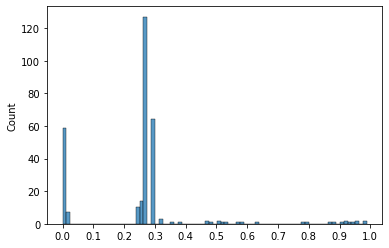

In [12]:
sns.histplot(data=(customers_clean.isnull()).sum() / len(customers_clean))
plt.xticks(ticks=np.arange(0,1.05,0.1));

In [13]:
cols_null[cols_null>0.3].sort_values()

KKK                          0.313401
REGIOTYP                     0.313401
D19_GESAMT_DATUM             0.315864
ALTER_HH                     0.358707
D19_VERSAND_DATUM            0.381640
D19_GESAMT_OFFLINE_DATUM     0.465928
D19_GESAMT_ONLINE_DATUM      0.468766
D19_GESAMT_ANZ_24            0.478586
AGER_TYP                     0.504759
D19_VERSAND_ONLINE_DATUM     0.509293
D19_VERSAND_OFFLINE_DATUM    0.522097
D19_VERSAND_ANZ_24           0.534740
KBA05_BAUMAX                 0.571531
D19_GESAMT_ANZ_12            0.584387
D19_VERSAND_ANZ_12           0.638167
D19_TELKO_DATUM              0.777007
D19_BANKEN_DATUM             0.797080
D19_BANKEN_ONLINE_DATUM      0.874423
D19_VERSI_ANZ_24             0.880930
D19_BANKEN_ANZ_24            0.906335
D19_TELKO_OFFLINE_DATUM      0.916635
D19_VERSI_ANZ_12             0.924780
D19_TELKO_ANZ_24             0.930911
D19_BANKEN_ANZ_12            0.939985
D19_BANKEN_OFFLINE_DATUM     0.961127
D19_TELKO_ANZ_12             0.962510
TITEL_KZ    

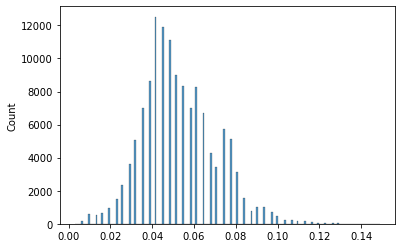

In [59]:
# Drop rows with over 20% missing values
customers_clean_dro = customers_clean[(customers_clean.isnull().sum(1) / len(customers_clean.columns) <= 0.2)].copy()
sns.histplot(data=(customers_clean_dro.isnull()).sum(1) / len(customers_clean.columns));


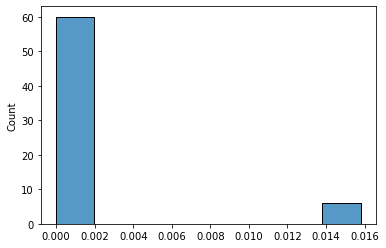

In [60]:
# Drop columns with over 20% missing values
customers_clean_dro = customers_clean_dro[customers_clean.columns[(customers_clean.isnull().sum(0) / len(customers_clean) <= 0.2)]].copy()
sns.histplot(data=(customers_clean_dro.isnull()).sum(0) / len(customers_clean));

### Imputation

In [104]:
from sklearn.impute import SimpleImputer
simple_imp = SimpleImputer(strategy='most_frequent')

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

In [62]:
customers_imputed = simple_imp.fit_transform(customers_clean_dro)

In [63]:
pd.DataFrame(customers_imputed).isnull().sum().sum()

0

__kNN Imputer__

In [105]:
knn_imputer = KNNImputer(n_neighbors=3, weights="uniform")

In [106]:
customers_knn_imputed = knn_imputer.fit_transform(customers_clean_dro)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [64]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [81]:
pca = PCA()
pca = pca.fit(X=StandardScaler().fit_transform(customers_imputed))

cus_pca = pca.transform(X=StandardScaler().fit_transform(customers_imputed))

0.9999999999999998


<BarContainer object of 66 artists>

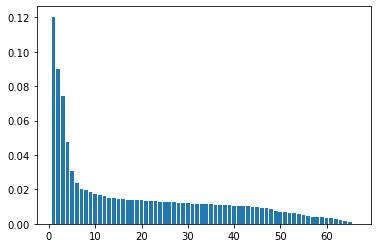

In [82]:
print(np.sum(pca.explained_variance_ratio_))
plt.bar(x=range(1,len(customers_clean_dro.columns)+1) , height=pca.explained_variance_ratio_)

<BarContainer object of 66 artists>

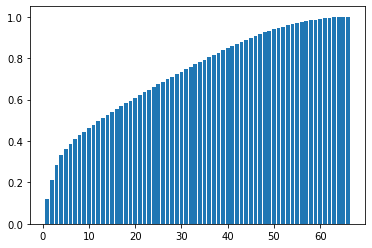

In [83]:
plt.bar(x=range(1,len(customers_clean_dro.columns)+1) , height=np.cumsum(pca.explained_variance_ratio_))

In [85]:
inertia = []

for n_clus in range(2,41):
    kmeans = KMeans(n_clusters=n_clus)
    kmeans = kmeans.fit(cus_pca)
    inertia.append(kmeans.inertia_)

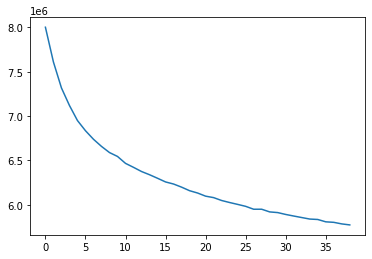

In [86]:
plt.plot(inertia)

In [102]:
inertia = []

for n_clus in range(2,41):
    kmeans = KMeans(n_clusters=n_clus)
    kmeans = kmeans.fit(cus_pca[:,:50])
    inertia.append(kmeans.inertia_)

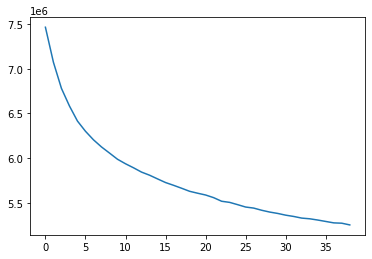

In [103]:
plt.plot(inertia)

__KNN Imputed KMeans__

0.9999999999999999


<BarContainer object of 66 artists>

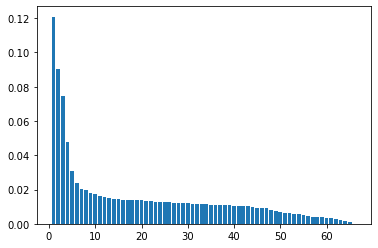

In [109]:
pca = PCA()
pca = pca.fit(X=StandardScaler().fit_transform(customers_knn_imputed))

cus_pca = pca.transform(X=StandardScaler().fit_transform(customers_knn_imputed))

print(np.sum(pca.explained_variance_ratio_))
plt.bar(x=range(1,len(customers_clean_dro.columns)+1) , height=pca.explained_variance_ratio_)

<BarContainer object of 66 artists>

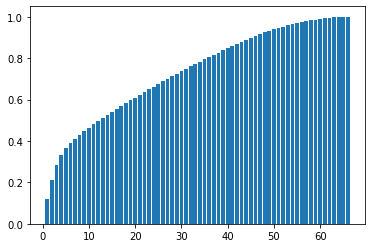

In [110]:
plt.bar(x=range(1,len(customers_clean_dro.columns)+1) , height=np.cumsum(pca.explained_variance_ratio_))

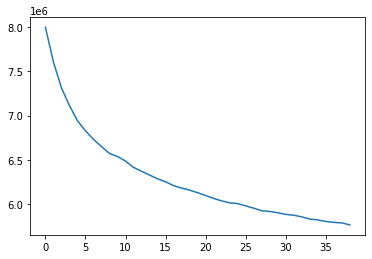

In [111]:
inertia = []

for n_clus in range(2,41):
    kmeans = KMeans(n_clusters=n_clus)
    kmeans = kmeans.fit(cus_pca)
    inertia.append(kmeans.inertia_)
    
plt.plot(inertia)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')